* [Project Description](#Description)
* [Exploratory Data Analysis EDA](#EDA)
    * [Bar histograms](#histograms)
    * [Heatmap](#Heatmap)
* [Build churn prediction model](#Build)
* [User Clustering](#Clustering)
* [Conclusions](#Conclusions)

# Description of the project <a id="Description"></a>

The network of fitness centers "Bodybuilder-datascientist" develops a strategy for interacting with users based on analytical data.

A common problem for fitness clubs and other services is the outflow of customers. How to understand that the user is no longer with you? You can add to the outflow those who asked to close the contract or deleted the account. However, customers do not always leave defiantly: they often stop using the service quietly.
Churn indicators are industry specific. When a user rarely but steadily buys in an online store, it doesn’t look like he “fell off”. But if you don’t visit a channel with daily updated content for two weeks, things are bad: the subscriber got bored and seems to have left you.
For a fitness center, we can consider that a client has been churned if he has never visited the gym in the last month. Of course, it is possible that he left for Bali and upon arrival will definitely continue to go to fitness. However, the opposite is more often the case. If a client started a new life on Monday, went to the gym for a bit, and then disappeared, most likely he will not return.

To combat churn, Bodybuilder Data Scientist's customer service department has digitized many user profiles. Your task is to analyze and prepare an action plan for customer retention. Namely:

- learn to predict the probability of outflow (at the level of the next month) for each client;
- form typical portraits of users: identify several of the most striking groups and characterize their main properties;
- analyze the main features that most strongly affect the outflow;
- formulate the main conclusions and develop recommendations for improving the quality of work with clients:
     - identify target customer groups;
     - propose measures to reduce churn;
     - to define other features of interaction with clients.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

In [4]:
print(df.shape)
df.columns = df.columns.str.lower()
df.head() 

(4000, 14)


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


- 'Churn' — outflow fact in the current month;
- Current fields in the dataset:
    - User data for the previous month before checking the outflow fact:
        - 'gender'
        - 'Near_Location' - living or working in the area where the fitness center is located
        - 'Partner' - an employee of the club's partner company (cooperation with companies whose employees can receive discounts for a subscription - in this case, the fitness center stores information about the client's employer)
        - Promo_friends - the fact of the initial entry as part of the "bring a friend" promotion (used a promo code from a friend when paying for the first subscription)
        - 'Phone' — availability of a contact phone number
        - 'Age' — age
        - 'Lifetime' - time since the first access to the fitness center (in months)
    - Information based on the log of visits, purchases and information about the current status of the client's subscription
        - 'Contract_period' — duration of the current active subscription (month, 3 months, 6 months, year)
        - 'Month_to_end_contract' — term until the end of the current active subscription (in months)
        - 'Group_visits' — the fact of attending group classes
        - 'Avg_class_frequency_total' — the average frequency of visits per week for the entire time since the start of the subscription
        - 'Avg_class_frequency_current_month' — average frequency of visits per week for the previous month
        - 'Avg_additional_charges_total' — total revenue from other services of the fitness center: cafe, sports goods, beauty and massage salon

In [5]:
df.info() #all data is clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

# Exploratory Data Analysis (EDA) <a id="EDA"></a>

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


On average, everything is calm - we have approximately the same spread for men and women and there is no strong difference in age. There is an interesting outlier in the Lifetime column - some visitor has been in the hall for 31 months (almost 3 years), and on average the hall is visited up to 3 times a week, with the exception of a person who comes there 6 days out of 7 from the start of the period.

In [7]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


We see that for churn = 0 (those who stayed), on average, older people (almost 30 years old) are inherent, with an average frequency of visiting the hall 2 times a week for the previous month and have been customers of the hall for 4 months already. In most cases, this client receives a partner discount from the company for visiting the hall. His contract is likely for 6 months.
On the contrary, a client who left the hall churn = 1 younger, on average 27 years old, is a client on average no more than 1 month and most likely took a subscription for 3 months. He rarely has an affiliate discount from the company.

### Bar charts <a id="histograms"></a>

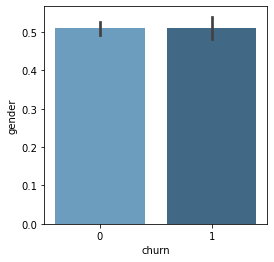

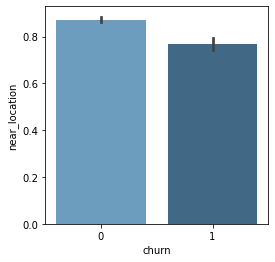

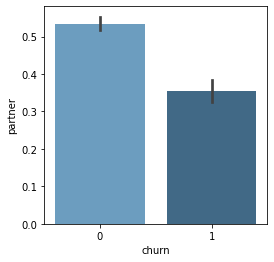

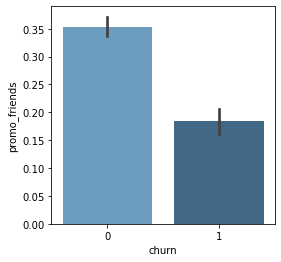

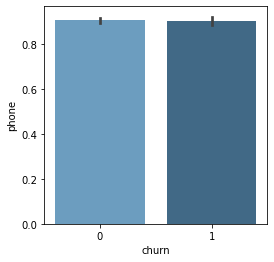

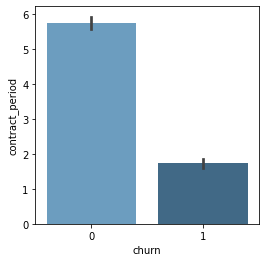

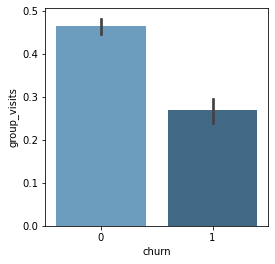

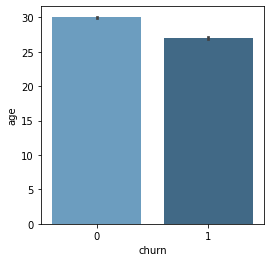

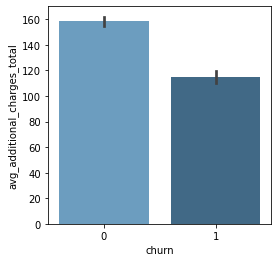

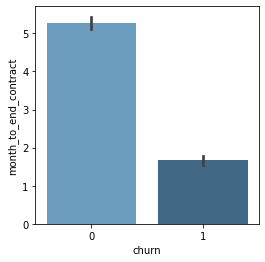

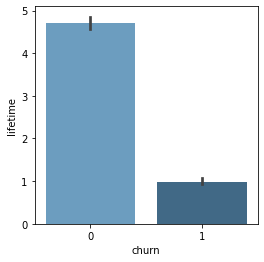

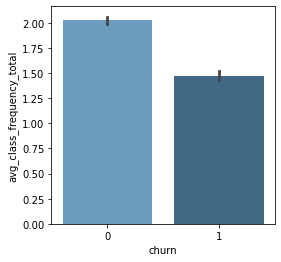

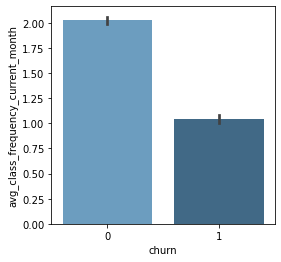

In [8]:
for col in df.drop('churn', axis = 1).columns: 
    plt.figure(figsize=(4, 4))
    sns.barplot(x="churn", y=col, data=df, palette="Blues_d")
    plt.show()

### Heatmap <a id="Heatmap"></a>


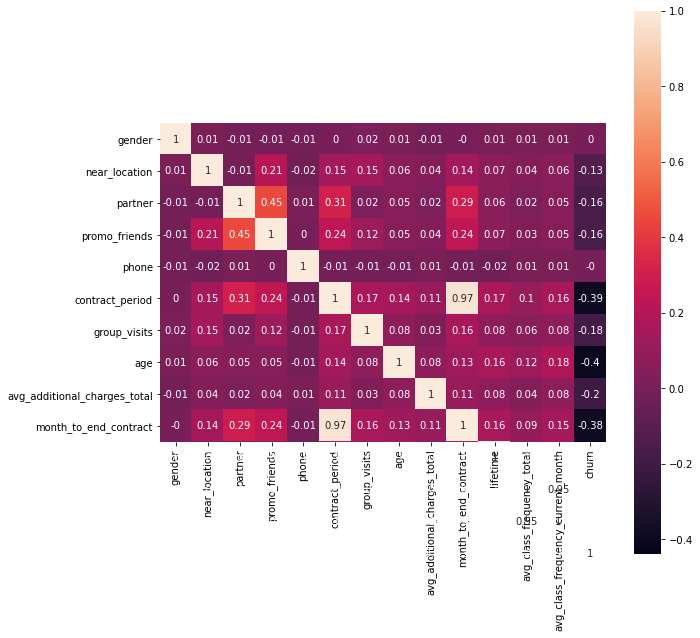

In [9]:
#построим и отрисуем матрицу корреляций
cm = df.corr().round(2) #вычисляем матрицу корреляций

#нарисуем тепловую карту с подписями для матрицы корреляций
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot = True, square=True)#ваш код здесь
ax.set_ylim(
    10,0)
plt.show()

Most of all, the connection with the outflow was found in the columns "month_to_end_contract", age and contract period. In contrast, gender and having a phone number have little to no effect on churn rates.
Clients that are part of the "partner" and "group_visits" programs leave less frequently than clients that do not have this option. Also, clients with a lower contact period leave more often - it was probably from a three-month trial period and they didn’t like something, they decided not to take a longer term (6 or 12 months) and their lifetime, respectively, is much lower.

# Building a user churn prediction model <a id="Building"></a>

In [10]:
X = df.drop('churn', axis = 1)
y = df['churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

print(X_train_st[:5])

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)


[[ 0.96619602  0.43033148  1.02339868 -0.66734383 -3.05329013 -0.80408577
  -0.84280208 -0.682639    0.8351644  -0.78713912 -0.9919009  -0.16257904
  -0.39978493]
 [-1.03498667  0.43033148 -0.9771363  -0.66734383  0.32751555 -0.80408577
  -0.84280208 -0.682639   -0.53243535 -0.78713912 -0.9919009  -1.16767761
  -1.56162601]
 [ 0.96619602 -2.32379001  1.02339868  1.49847793  0.32751555  0.29976428
  -0.84280208  0.54457718 -1.47121501  0.16841672  1.1213367  -0.14789419
  -0.05848145]
 [-1.03498667  0.43033148 -0.9771363  -0.66734383  0.32751555  1.62438434
  -0.84280208  0.23777313  1.48682485  1.60175048  0.3288726   1.22096866
   1.30455254]
 [-1.03498667  0.43033148  1.02339868  1.49847793  0.32751555 -0.80408577
  -0.84280208  0.54457718 -1.09788803 -0.78713912 -0.9919009  -1.91770149
  -1.66462814]]


In [11]:
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.87
	Recall: 0.81


In [12]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)  # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]# Ваш код здесь
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.86
	Recall: 0.84


We see that the Logistic Regression behaves better in all indicators (Accuracy, Precision and Recall)

# User clustering <a id="Clustering"></a>

# Step 4: Cluster Users

    Set aside the churn column and cluster the objects (users):
        Standardize your data.
        Build a distance matrix with the linkage() function on a standardized feature matrix and draw a dendrogram. Attention: drawing a dendrogram may take time! Based on the resulting graph, guess how many clusters can be identified.
        Train a clustering model based on the K-Means algorithm and predict customer clusters. We will agree to take n=5 as the number of clusters so that your results can be compared with the results of other students. However, of course, in life no one will tell you the correct answer, and the decision is up to you (based on the study of the graph from the previous paragraph).
        Look at the averages of the features for the clusters. Is it possible to notice something right away?
        Plot the feature distributions for the clusters. Can you see something in them?
        For each resulting cluster, calculate the churn rate (using the groupby() method). Do they differ in

In [13]:
sc = StandardScaler()
X_sc = sc.fit_transform(df)

linked = linkage(X_sc, method = 'ward') 

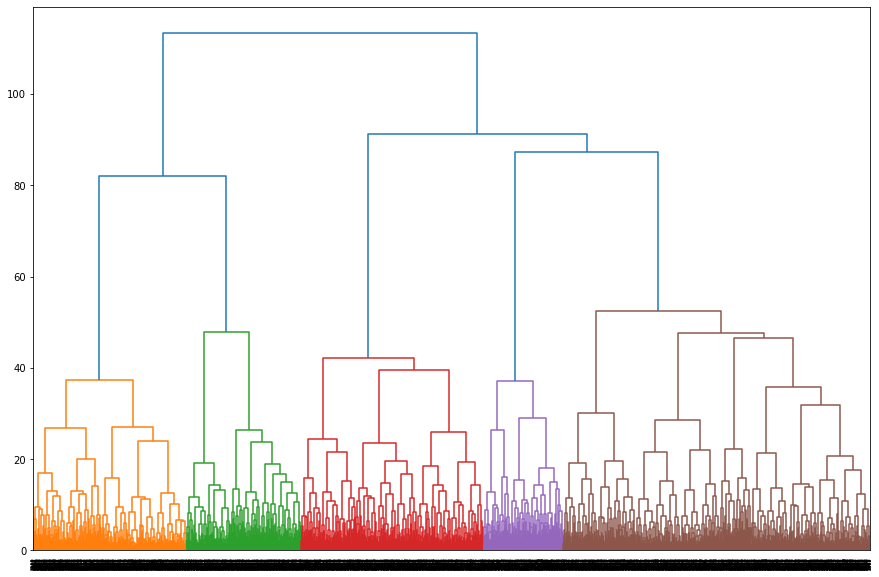

In [14]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 
#Предложенное оптимальное число кластеров 5 — пять разных цветов на графике.

In [15]:
km = KMeans(n_clusters = 5) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.472832,0.826590,0.455491,0.261272,1.000000,2.751445,0.382659,30.046243,151.641903,2.546821,4.634682,1.169503,1.168325,0.001156
1,0.526178,0.869110,0.471204,0.308901,0.000000,4.816754,0.429319,29.340314,144.517762,4.502618,3.955497,1.857525,1.727260,0.261780
2,0.506908,0.759830,0.341126,0.179596,0.996812,1.566419,0.257173,26.907545,114.993470,1.513284,0.975558,1.448150,1.025562,0.997875
3,0.503125,0.938542,0.767708,0.562500,1.000000,11.200000,0.559375,29.880208,162.783361,10.251042,4.718750,2.028887,2.023255,0.015625
4,0.552817,0.842723,0.369718,0.212441,0.998826,2.674883,0.440141,29.969484,160.701876,2.468310,4.613850,2.916013,2.923022,0.007042


Clustering the data, you can see that those who go to group classes also have Promo_friends and have the longest contract on average. The lowest churn rate is for the cluster that visits the gym on average 2 times a week and has the longest lifetime (time since the first visit to the fitness center). Those who have the highest churn process have the least visits to the gym and their lifetime is the lowest, they are also the youngest of all other clusters.

# Conclusions <a id="Conclusions"></a>

After the experiment, it was found that the use of the Logistic Regression model is the most reasonable - its metrics cope much better with the accuracy of the task, in contrast to the Random Forest metrics. The decision was made based on Accuracy, Precision and Recall metrics

Important principles:
- To retain clients, you can somehow force them to visit the hall more than once a week. For example, to give certain bonuses or a discount for those who visit the hall more than the conditional 9-10 times a month. Let's say, when visiting the hall from 10 times a month, a discount is issued for the purchase of a new (three / half-year subscription) subscription. On average, for those who visit the gym about twice a week, lifetime was higher
- If we want to increase net users with longer term subscriptions, we can advertise the Promo_friends program more actively. It was found that invited friends are more likely to participate in group classes and their contract is one of the longest on average.
- It was also revealed that the lowest churn rate for clients included in the "Partner" column is an employee of the club's partner company. In this case, we could increase the number of companies in this area. By the way, they are most often part of the "promo_friends" campaign, which means that it is more pleasant to work with fellow friends in the gym than alone and increases the number of client visits. They, apparently, are more satisfied with the products of the hall - their purchasing power is above all.
- Clients with a shorter contract leave more often than clients with a longer contact. In this case, you can reduce the price difference and make the six-month period more profitable for the purchase. In this case, the client will have more time to return to the hall if the subscription is initially longer.

* [Project Description](#Description)
* [Exploratory Data Analysis EDA](#EDA)
    * [Bar histograms](#histograms)
    * [Heatmap](#Heatmap)
* [Build churn prediction model](#Build)
* [User Clustering](#Clustering)
* [Conclusions](#Conclusions)